In [2]:
import sys
sys.path.append('../src/')

import config
import json
import logging
import scanpy as sc

from ete3 import Tree, TreeStyle, NodeStyle, TextFace
from refcm import RefCM

config.start_logging(logging.DEBUG)

# Cell types found in the Allen-Brain datasets (see [here](../experiments/hierarchical.ipynb)).

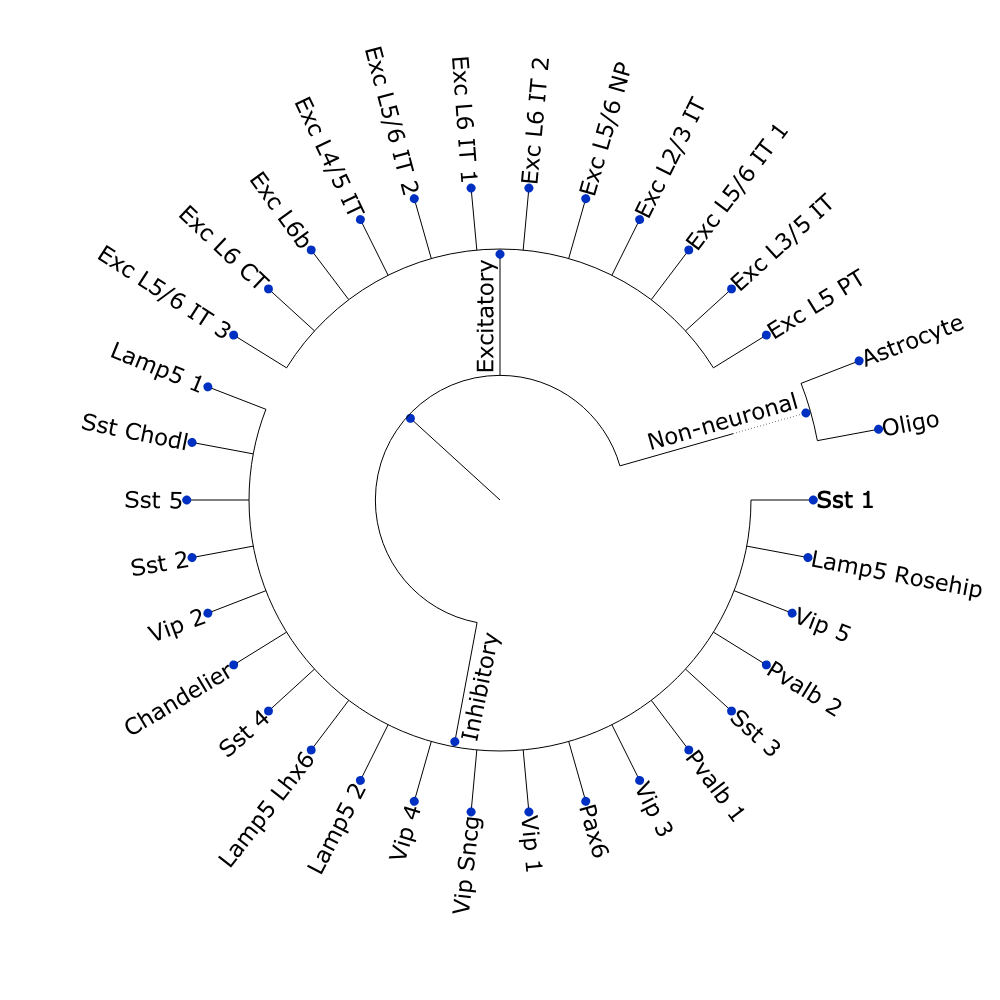

In [27]:
# retrieve hierarchy
mtg = sc.read_h5ad('../data/MTG.h5ad')
labels = mtg.obs[['labels3', 'labels34']].set_index('labels3')
coarse_levels = labels.index.unique().to_list()
hierarchy = {
    level: labels.loc[level].drop_duplicates().values.flatten().tolist()
    for level in coarse_levels
}

# create ete3 tree and styling
tree = Tree()

ts = TreeStyle()
ts.mode = "c"
ts.arc_span = 360
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle["size"] = 3

# populate tree object
for parent, children in hierarchy.items():
    p = Tree()
    p.set_style(nstyle)
    p.add_face(TextFace(parent), position='branch-top', column=0)
    for child in children:
        c = Tree()
        c.set_style(nstyle)
        c.add_face(TextFace(child), position='branch-right', column=0)
        p.add_child(c, name=child, dist=.5)
    
    tree.add_child(p, name=parent, dist=1)

# render
tree.render("allenbrain.png", w=3000, units="px", dpi=400, tree_style=ts)
tree.render("%%inline", w=1000, units="px", dpi=400, tree_style=ts)

# Cell type tree used by RefCM

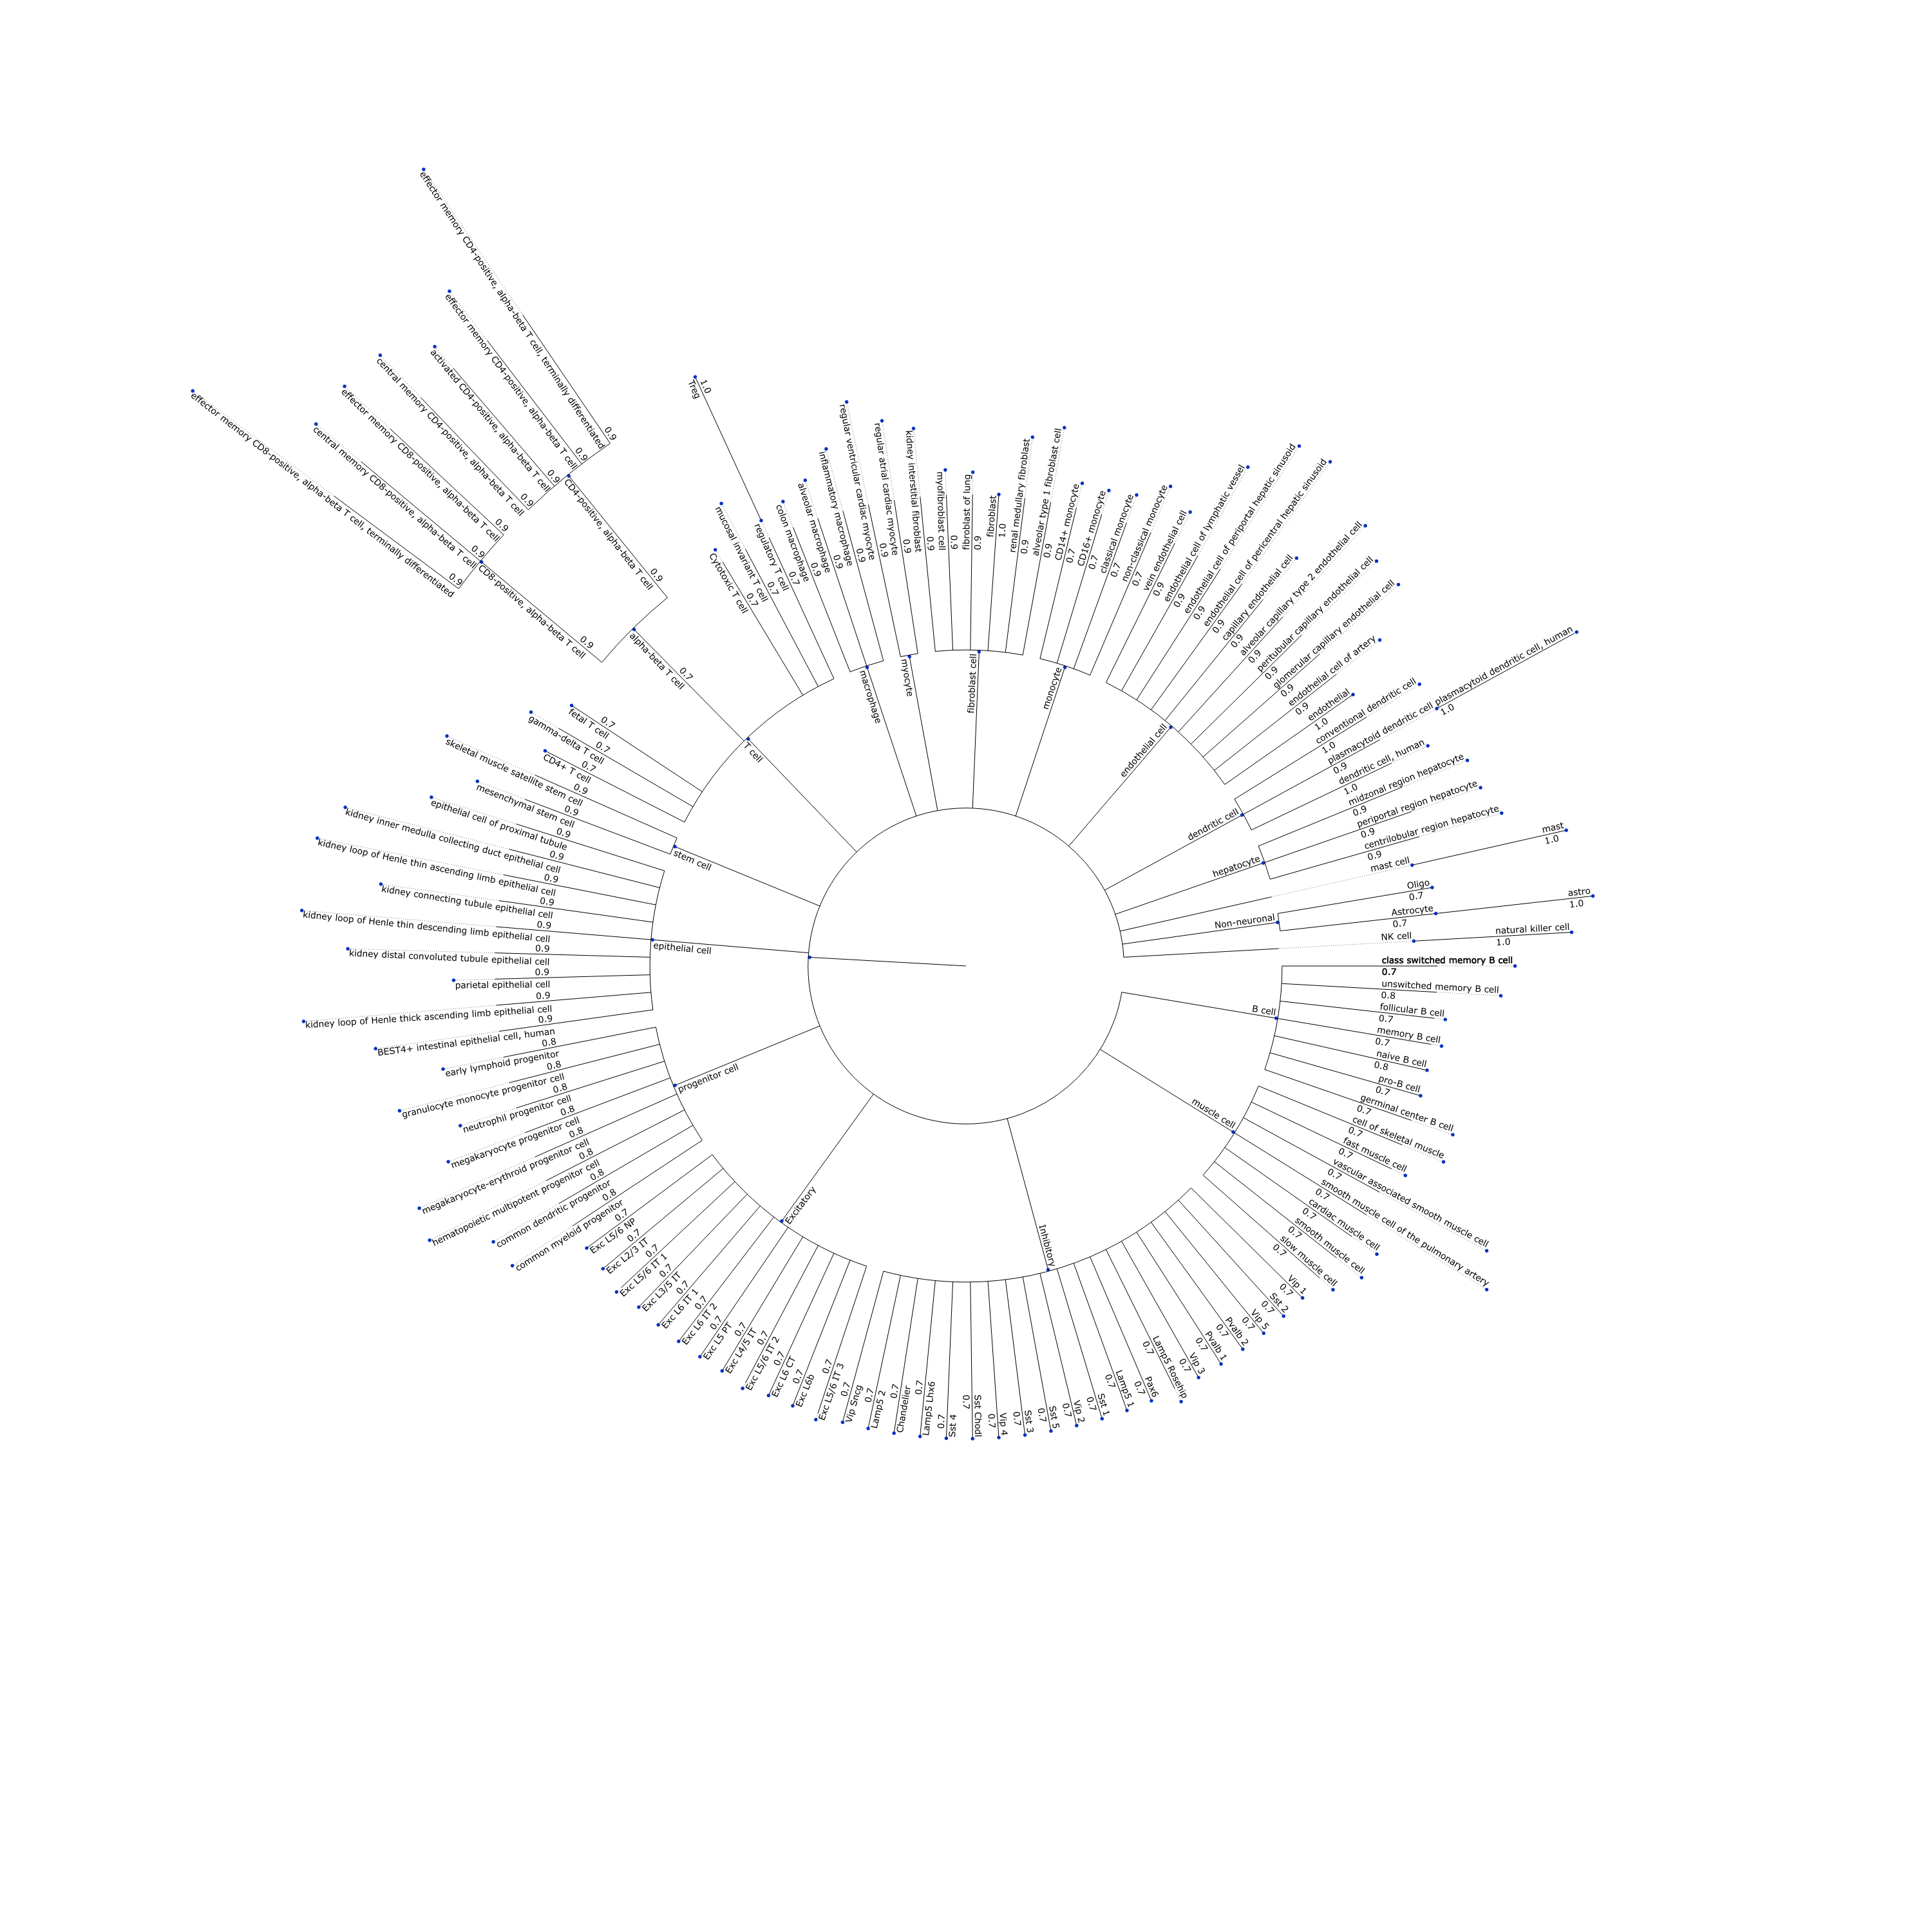

In [31]:
with open(config.TREE_FILE, 'r') as f:
    d = json.load(f)

t = {c: (p, s) for p, c, s in d}


# create ete3 tree and styling
tree = Tree()

ts = TreeStyle()
ts.mode = "c"
ts.arc_start = 0
ts.arc_span = 360
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle["size"] = 3

# iterate through list of links, adding whichever possible
links = set([tuple(c) for c in d])
ndict = {}

while len(links) != 0:
    p, c, s = links.pop()
    
    # if connected to root, add to root
    if t.get(p) is None and ndict.get(p) is None:
        p_node = Tree()
        p_node.add_face(TextFace(p), position='branch-top', column=0)
        p_node.set_style(nstyle)
        
        tree.add_child(p_node, name=p, dist=1)
        ndict[p] = p_node
    
    # add child, if parent already added to tree
    p_node = ndict.get(p)
    if p_node is not None:
        c_node = Tree()
        c_node.add_face(TextFace(c), position='branch-top', column=0)
        c_node.add_face(TextFace(str(s)), position='branch-bottom', column=0)
        c_node.set_style(nstyle)
        
        p_node.add_child(c_node, name=c, dist=1)
        ndict[c] = c_node
    
    # otherwise, add back to set to add later
    else:
        links.add((p, c, s))
        

# render and save
tree.render("typetree.png", w=3000, units="px", dpi=400, tree_style=ts)
tree.render("%%inline", w=3000, units="px", dpi=400, tree_style=ts)